In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
data=pd.read_csv('/content/bitcoin_data_2014_to_2025.csv')

In [8]:
data['Date']=pd.to_datetime(data['Date'])

In [9]:
print(data.head(2))
print(data.tail(2))
print(data.shape)
print(data.dtypes)
print(data.info)
print(data.describe)


        Date       Close        High         Low        Open    Volume
0 2014-09-17  457.334015  468.174011  452.421997  465.864014  21056800
1 2014-09-18  424.440002  456.859985  413.104004  456.859985  34483200
           Date         Close          High           Low          Open  \
4093 2025-12-01  86321.570312  90398.156250  83862.250000  90389.109375   
4094 2025-12-02  87785.914062  87785.914062  86223.601562  86306.093750   

           Volume  
4093  87962894424  
4094  69972828160  
(4095, 6)
Date      datetime64[ns]
Close            float64
High             float64
Low              float64
Open             float64
Volume             int64
dtype: object
<bound method DataFrame.info of            Date         Close          High           Low          Open  \
0    2014-09-17    457.334015    468.174011    452.421997    465.864014   
1    2014-09-18    424.440002    456.859985    413.104004    456.859985   
2    2014-09-19    394.795990    427.834991    384.532013    424.10299

In [10]:
!pip install tensorflow scikit-learn


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [12]:
df = data.copy()
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# 1. log-return
df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))

# 2. moving averages
df['ma7'] = df['Close'].rolling(window=7).mean()
df['ma21'] = df['Close'].rolling(window=21).mean()

# 3. volatility (7-day rolling std of log returns)
df['volatility_7'] = df['log_return'].rolling(window=7).std()

# 4. RSI(14)
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = np.where(delta > 0, delta, 0.0)
    loss = np.where(delta < 0, -delta, 0.0)

    gain_rolling = pd.Series(gain).rolling(window=period).mean()
    loss_rolling = pd.Series(loss).rolling(window=period).mean()

    rs = gain_rolling / (loss_rolling + 1e-9)
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['rsi14'] = compute_rsi(df['Close'], period=14)

# Drop NaN rows created by rolling / shift
df = df.dropna().reset_index(drop=True)

feature_cols = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'log_return', 'ma7', 'ma21', 'volatility_7', 'rsi14'
]
target_col = 'log_return'

print(df[['Date'] + feature_cols].head())


        Date        Open        High         Low       Close    Volume  \
0 2014-10-07  330.584015  339.247009  320.481995  336.187012  49199900   
1 2014-10-08  336.115997  354.364014  327.187988  352.940002  54736300   
2 2014-10-09  352.747986  382.726013  347.687012  365.026001  83641104   
3 2014-10-10  364.687012  375.066986  352.963013  361.562012  43665700   
4 2014-10-11  361.362000  367.191010  355.950989  362.299011  13345200   

   log_return         ma7        ma21  volatility_7      rsi14  
0    0.018336  347.691572  387.352142      0.039486  17.642549  
1    0.048630  343.309431  382.380999      0.047395  27.775351  
2    0.033671  341.874289  379.551761      0.049985  35.319233  
3   -0.009535  342.167149  377.969190      0.047236  36.159745  
4    0.002036  346.943294  375.749906      0.026200  37.649076  


In [13]:
# define test start as 3 months before last date
last_date = df['Date'].max()
test_start_date = last_date - pd.DateOffset(months=3)
print("Last date:", last_date)
print("Test start date:", test_start_date)

# train+val vs test
df_trainval = df[df['Date'] < test_start_date].copy()
df_test     = df[df['Date'] >= test_start_date].copy()

print("Train+Val size:", df_trainval.shape)
print("Test size     :", df_test.shape)


Last date: 2025-12-02 00:00:00
Test start date: 2025-09-02 00:00:00
Train+Val size: (3983, 11)
Test size     : (92, 11)


In [14]:
values_X = df_trainval[feature_cols].values
values_y = df_trainval[target_col].values

n_tv = len(df_trainval)
train_size = int(n_tv * 0.85)   # 85% train, 15% val

X_train = values_X[:train_size]
y_train = values_y[:train_size]
X_val   = values_X[train_size:]
y_val   = values_y[train_size:]

X_test  = df_test[feature_cols].values
y_test  = df_test[target_col].values

X_train.shape, X_val.shape, X_test.shape


((3385, 10), (598, 10), (92, 10))

In [15]:
scaler_X = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled   = scaler_X.transform(X_val)
X_test_scaled  = scaler_X.transform(X_test)


In [16]:
def create_sequences(X, y, window_size):
    X_seq, y_seq = [], []
    for i in range(window_size, len(X)):
        X_seq.append(X[i-window_size:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

window_size = 60  # you can try 30, 60, 90 etc.

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, window_size)
X_val_seq,   y_val_seq   = create_sequences(X_val_scaled,   y_val,   window_size)
X_test_seq,  y_test_seq  = create_sequences(X_test_scaled,  y_test,  window_size)

X_train_seq.shape, X_val_seq.shape, X_test_seq.shape


((3325, 60, 10), (538, 60, 10), (32, 60, 10))

In [17]:
def build_lstm_model(window_size, n_features,
                     lstm_units_1=64,
                     lstm_units_2=32,
                     dropout_rate=0.2):
    model = Sequential()

    model.add(LSTM(lstm_units_1, return_sequences=True,
                   input_shape=(window_size, n_features)))
    model.add(Dropout(dropout_rate))

    model.add(LSTM(lstm_units_2, return_sequences=False))
    model.add(Dropout(dropout_rate))

    model.add(Dense(1))  # output: next-day log_return

    model.compile(optimizer='adam', loss='mse')
    return model

n_features = len(feature_cols)
model = build_lstm_model(window_size, n_features,
                         lstm_units_1=64,
                         lstm_units_2=32,
                         dropout_rate=0.2)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,649 (123.63 KB)

 Trainable params: 31,649 (123.63 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
batch_size = 32
epochs = 100

es = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=[es],
    verbose=1
)


Epoch 1/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0043 - val_loss: 9.3029e-04
Epoch 2/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 3/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0017 - val_loss: 8.3119e-04
Epoch 4/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0017 - val_loss: 9.1738e-04
Epoch 5/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0016 - val_loss: 8.9310e-04
Epoch 6/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0015 - val_loss: 6.9938e-04
Epoch 7/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0014 - val_loss: 6.5396e-04
Epoch 8/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0014 - val_loss: 6.5288e-04
Epoch 9/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0014 - val_loss: 6.5668e-04
Epoch 10/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0014 - val_loss: 8.5215e-04
Epoch 11/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0014 - val_loss: 8.75

In [19]:
y_pred_test = model.predict(X_test_seq).flatten()

rmse_ret = np.sqrt(mean_squared_error(y_test_seq, y_pred_test))
mae_ret  = mean_absolute_error(y_test_seq, y_pred_test)

print(f"Test RMSE (log-return): {rmse_ret:.6f}")
print(f"Test MAE  (log-return): {mae_ret:.6f}")

actual_dir   = (y_test_seq > 0).astype(int)
predicted_dir = (y_pred_test > 0).astype(int)
direction_acc = (actual_dir == predicted_dir).mean()
print(f"Direction accuracy (test): {direction_acc:.2%}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
Test RMSE (log-return): 0.024782
Test MAE  (log-return): 0.020200
Direction accuracy (test): 53.12%


In [20]:
# close prices for test period
test_close = df_test['Close'].values

# y_test_seq / y_pred_test correspond to indices from window_size .. len(test)-1
# previous day's price index: from window_size-1 .. len(test)-2

prev_close_for_pred = test_close[window_size-1:-1]        # shape = len(y_test_seq)
pred_close_test = prev_close_for_pred * np.exp(y_pred_test)

# actual close = test_close[window_size:]
actual_close_test = test_close[window_size:]

rmse_price = np.sqrt(mean_squared_error(actual_close_test, pred_close_test))
mae_price  = mean_absolute_error(actual_close_test, pred_close_test)
mape_price = np.mean(np.abs((actual_close_test - pred_close_test) / actual_close_test)) * 100

print(f"Test RMSE (price): {rmse_price:.2f}")
print(f"Test MAE  (price): {mae_price:.2f}")
print(f"Test MAPE (price %): {mape_price:.2f}%")


Test RMSE (price): 2385.66
Test MAE  (price): 1943.30
Test MAPE (price %): 2.04%


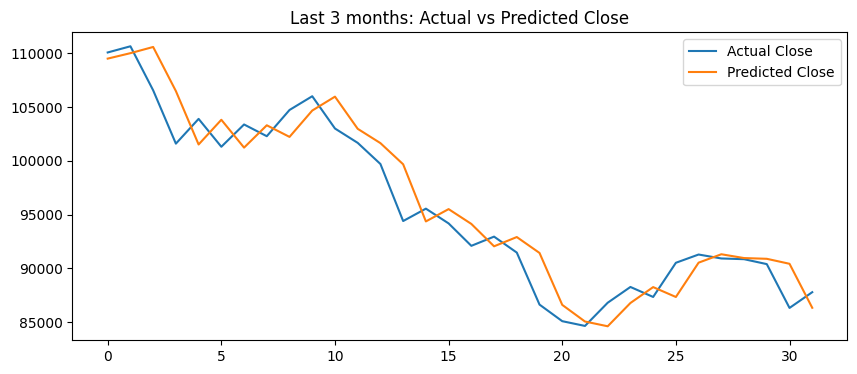

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(actual_close_test, label='Actual Close')
plt.plot(pred_close_test, label='Predicted Close')
plt.title('Last 3 months: Actual vs Predicted Close')
plt.legend()
plt.show()


In [23]:
del model
import gc
gc.collect()


4209

In [24]:
# FULL DATA
X_full = df[feature_cols].values
y_full = df[target_col].values

# Scale on full data (final scaler)
scaler_X_full = MinMaxScaler(feature_range=(0,1))
X_full_scaled = scaler_X_full.fit_transform(X_full)

# Create sequences
window_size = 60  # same as before
X_full_seq, y_full_seq = create_sequences(X_full_scaled, y_full, window_size)

# Build final model
model_final = build_lstm_model(
    window_size=window_size,
    n_features=len(feature_cols),
    lstm_units_1=64,
    lstm_units_2=32,
    dropout_rate=0.2
)

# Train
es = EarlyStopping(
    monitor='loss',
    patience=10,
    restore_best_weights=True
)

history = model_final.fit(
    X_full_seq, y_full_seq,
    epochs=100,
    batch_size=32,
    callbacks=[es],
    verbose=1
)


Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0037
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0015
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0015
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0014
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0015
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0013
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0016
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0012
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0013
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0012
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0012
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0012
Epoch 13/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0013
Epoch 14/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0011
Epoch 15/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step

In [25]:
model_final.save("btc_lstm_logreturn_multifeature.h5")

import joblib
joblib.dump(scaler_X_full, "btc_feature_scaler.pkl")
joblib.dump(feature_cols, "btc_feature_columns.pkl")


['btc_feature_columns.pkl']

In [28]:
from tensorflow.keras.models import load_model
import joblib

# Load model WITHOUT compiling (avoids 'mse' deserialization issue)
model = load_model("btc_lstm_logreturn_multifeature.h5", compile=False)

# If you want to train further later, you can recompile manually:
# from tensorflow.keras.optimizers import Adam
# model.compile(optimizer=Adam(), loss='mse')

scaler = joblib.load("btc_feature_scaler.pkl")
feature_cols = joblib.load("btc_feature_columns.pkl")


In [30]:
# Prepare latest window (df must contain latest candles)
X_latest = df[feature_cols].values
X_latest_scaled = scaler.transform(X_latest)

last_window = X_latest_scaled[-window_size:].reshape(1, window_size, len(feature_cols))

next_log_return = model.predict(last_window)[0,0]

last_price = df['Close'].iloc[-1]
next_price = last_price * np.exp(next_log_return)

print("Predicted next-day close:", next_price)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
Predicted next-day close: 87279.5438856245


In [31]:
def predict_future_days(
    model,
    df,
    feature_cols,
    scaler,
    window_size=60,
    future_days=3
):
    df_temp = df.copy()
    predictions = []

    last_price = df_temp['Close'].iloc[-1]

    for step in range(future_days):
        # scale features
        X_all = df_temp[feature_cols].values
        X_all_scaled = scaler.transform(X_all)

        # last window
        last_window = X_all_scaled[-window_size:].reshape(
            1, window_size, len(feature_cols)
        )

        # predict log-return
        next_log_return = model.predict(last_window, verbose=0)[0, 0]

        # reconstruct price
        next_price = last_price * np.exp(next_log_return)

        predictions.append(next_price)

        # create next row (minimal update)
        new_row = df_temp.iloc[-1].copy()
        new_row['Close'] = next_price
        new_row['log_return'] = next_log_return
        new_row['Date'] = df_temp['Date'].iloc[-1] + pd.Timedelta(days=1)

        df_temp = pd.concat(
            [df_temp, pd.DataFrame([new_row])],
            ignore_index=True
        )

        last_price = next_price

    return predictions


In [32]:
future_prices = predict_future_days(
    model=model,
    df=df,
    feature_cols=feature_cols,
    scaler=scaler,
    window_size=window_size,
    future_days=3
)

dates = pd.date_range(
    start=df['Date'].iloc[-1] + pd.Timedelta(days=1),
    periods=3,
    freq='D'
)

for d, p in zip(dates, future_prices):
    print(d.date(), "→", round(p, 2))


2025-12-03 → 87279.54
2025-12-04 → 86767.45
2025-12-05 → 86253.55
